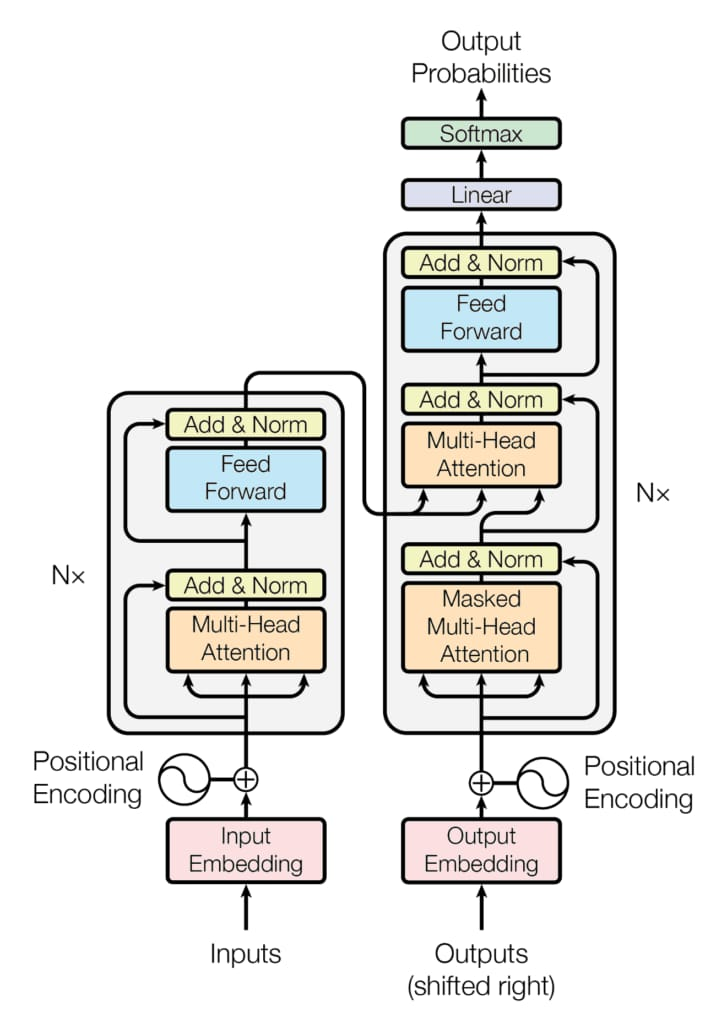

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class VisionTransformer:
    def __init__(self, 
                 input_shape=(180, 180, 3), 
                 num_classes=5, 
                 patch_size=16, 
                 embed_dim=256, 
                 num_heads=8, 
                 mlp_dim=512, 
                 num_transformer_layers=8,
                 dropout_rate=0.1):
        """
        Initialize Vision Transformer model for custom dataset
        
        Args:
            input_shape (tuple): Input image dimensions
            num_classes (int): Number of classification classes
            patch_size (int): Size of image patches
            embed_dim (int): Embedding dimension
            num_heads (int): Number of attention heads
            mlp_dim (int): Dimension of MLP hidden layer
            num_transformer_layers (int): Number of transformer layers
            dropout_rate (float): Dropout rate for regularization
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.num_transformer_layers = num_transformer_layers
        self.dropout_rate = dropout_rate
        
        # Build the model
        self.model = self._build_vision_transformer()
    
    def _patch_embedding(self, inputs):
        """
        Create patch embeddings
        
        Args:
            inputs (tensor): Input image tensor
        
        Returns:
            tensor: Patch embeddings and number of patches
        """
        # Calculate number of patches
        patch_h = self.input_shape[0] // self.patch_size
        patch_w = self.input_shape[1] // self.patch_size
        num_patches = patch_h * patch_w
        
        # Create patch embeddings
        patches = layers.Reshape((num_patches, 
                                  self.patch_size * self.patch_size * 3))(inputs)
        
        # Linear projection of flattened patches
        patch_embeddings = layers.Dense(
            self.embed_dim, 
            kernel_regularizer=regularizers.l2(1e-4)
        )(patches)
        
        return patch_embeddings, num_patches
    
    def _transformer_encoder(self, inputs):
        """
        Create transformer encoder block
        
        Args:
            inputs (tensor): Input tensor
        
        Returns:
            tensor: Transformed tensor
        """
        # Multi-head self-attention
        x = layers.MultiHeadAttention(
            num_heads=self.num_heads, 
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout_rate
        )(inputs, inputs)
        x = layers.LayerNormalization()(x + inputs)
        
        # MLP block
        mlp_out = layers.Dense(
            self.mlp_dim, 
            activation='gelu',
            kernel_regularizer=regularizers.l2(1e-4)
        )(x)
        mlp_out = layers.Dropout(self.dropout_rate)(mlp_out)
        mlp_out = layers.Dense(
            self.embed_dim,
            kernel_regularizer=regularizers.l2(1e-4)
        )(mlp_out)
        
        # Final layer normalization
        return layers.LayerNormalization()(x + mlp_out)
    
    def _build_vision_transformer(self):
        """
        Build complete Vision Transformer model
        
        Returns:
            tf.keras.Model: Compiled Vision Transformer model
        """
        # Input layer
        inputs = layers.Input(shape=self.input_shape)
        
        # Create patch embeddings
        patch_embeddings, num_patches = self._patch_embedding(inputs)
        
        # Add learnable classification token
        cls_token = tf.zeros((1, 1, self.embed_dim))
        x = tf.concat([cls_token, patch_embeddings], axis=1)
        
        # Position embeddings
        positions = layers.Embedding(
            input_dim=num_patches + 1, 
            output_dim=self.embed_dim
        )(tf.range(start=0, limit=num_patches + 1))
        
        # Add position embeddings
        x += positions
        
        # Transformer encoder layers
        for _ in range(self.num_transformer_layers):
            x = self._transformer_encoder(x)
        
        # Classification head
        x = layers.LayerNormalization()(x)
        x = layers.Flatten()(x[:, 0])
        x = layers.Dropout(self.dropout_rate)(x)
        outputs = layers.Dense(
            self.num_classes, 
            activation='softmax',
            kernel_regularizer=regularizers.l2(1e-4)
        )(x)
        
        # Create model
        model = models.Model(inputs=inputs, outputs=outputs)
        
        # Compile model
        model.compile(
            optimizer=optimizers.Adam(learning_rate=1e-4),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train(self, 
              train_generator, 
              validation_generator, 
              epochs=15, 
              steps_per_epoch=None,
              validation_steps=None):
        """
        Train the Vision Transformer using data generators
        
        Args:
            train_generator: Training data generator
            validation_generator: Validation data generator
            epochs (int): Number of training epochs
            steps_per_epoch (int, optional): Steps per epoch
            validation_steps (int, optional): Validation steps
        
        Returns:
            History object from model training
        """
        # Training
        history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps
        )
        
        return history
    
    def evaluate(self, test_generator, steps=None):
        """
        Evaluate model performance
        
        Args:
            test_generator: Test data generator
            steps (int, optional): Number of evaluation steps
        
        Returns:
            Evaluation metrics
        """
        return self.model.evaluate(test_generator, steps=steps)
    
    def predict(self, test_generator, steps=None):
        """
        Make predictions on test generator
        
        Args:
            test_generator: Test data generator
            steps (int, optional): Number of prediction steps
        
        Returns:
            Predicted class probabilities
        """
        return self.model.predict(test_generator, steps=steps)
    
    def save_model(self, filepath):
        """
        Save the trained model
        
        Args:
            filepath (str): Path to save the model
        """
        self.model.save(filepath)

# Main execution
def main():
    # Dataset parameters
    IMG_SIZE = (180, 180)
    BATCH_SIZE = 32
    EPOCHS = 15
    NUM_CLASSES = 5

    # Data augmentation and generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        'Training_set',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        'Training_set',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        subset='validation'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        'Testing_set',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse'
    )

    # Create Vision Transformer model
    vit = VisionTransformer(
        input_shape=(*IMG_SIZE, 3),
        num_classes=NUM_CLASSES,
        patch_size=18  # Adjusted to fit 180x180 image
    )

    # Train the model
    history = vit.train(
        train_generator, 
        validation_generator, 
        epochs=EPOCHS,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        validation_steps=validation_generator.samples // BATCH_SIZE
    )

    # Evaluate on test set
    test_loss, test_acc = vit.evaluate(
        test_generator, 
        steps=test_generator.samples // BATCH_SIZE
    )
    print(f'Test accuracy: {test_acc * 100:.2f}%')

    # Save the model
    vit.save_model('vision_transformer_model')

if __name__ == '__main__':
    main()

Found 4100 images belonging to 5 classes.
Found 1022 images belonging to 5 classes.
Found 1275 images belonging to 5 classes.
Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node 'model/tf.concat/concat' defined at (most recent call last):
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kk993\AppData\Local\Temp\ipykernel_3964\662430779.py", line 286, in <module>
      main()
    File "C:\Users\kk993\AppData\Local\Temp\ipykernel_3964\662430779.py", line 267, in main
      history = vit.train(
    File "C:\Users\kk993\AppData\Local\Temp\ipykernel_3964\662430779.py", line 172, in train
      history = self.model.fit(
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\layers\core\tf_op_layer.py", line 242, in _call_wrapper
      return self._call_wrapper(*args, **kwargs)
    File "C:\Users\kk993\anaconda3\envs\my_env\lib\site-packages\keras\layers\core\tf_op_layer.py", line 279, in _call_wrapper
      result = self.function(*args, **kwargs)
Node: 'model/tf.concat/concat'
ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [1,1,256] vs. shape[1] = [32,100,256]
	 [[{{node model/tf.concat/concat}}]] [Op:__inference_train_function_11336]